In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [53]:
raw_dataset = pd.read_csv("~/workspace/data/train.csv").values
np.random.shuffle(raw_dataset)
print(raw_dataset[0:10,:])
all_labels = raw_dataset[:,0]
all_features = raw_dataset[:,1:]/255
print(all_labels)
print(all_features);


[[8 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]
 ...
 [7 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]]
[8 3 3 ... 9 8 4]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [54]:
num_examples = all_labels.size;
a,b = num_examples*8//10, num_examples*9//10;
print(a)
print(b)

33600
37800


In [58]:
dataset = {
    'train_labels':all_labels[:a],
    'dev_labels':all_labels[a:b],
    'test_labels': all_labels[b:],
    
    'train_features':all_features[:a,:],
    'dev_features': all_features[a:b,:],
    'test_features':all_features[b:,:]
}
print(dataset)

{'train_labels': array([8, 3, 3, ..., 4, 8, 1]), 'dev_labels': array([6, 6, 0, ..., 2, 7, 2]), 'test_labels': array([8, 0, 0, ..., 9, 8, 4]), 'train_features': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'dev_features': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'test_features': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])}


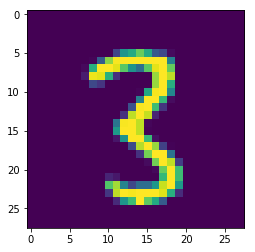

In [43]:
def plot_digit(pixels):
    plt.imshow(pixels.reshape(28,28))
    plt.show()

plot_digit(dataset['train_features'][10,:])


In [44]:
def input_nodes(num_features, num_labels):
    X = tf.placeholder(tf.float32, name = 'X', shape = [None, num_features])
    labels = tf.placeholder(tf.int64, name = 'labels', shape = [None])
    with tf.name_scope('labels_to_Y'):
        Y = tf.one_hot(labels, num_labels, name = 'Y')
    return X, labels, Y


In [45]:


def linear_layer(input_, in_size, out_size, name):
    with tf.variable_scope(name):
        W = tf.get_variable('W', initializer=tf.contrib.layers.xavier_initializer(), shape=[out_size, in_size])
        b = tf.get_variable('b', initializer=tf.zeros_initializer(), shape=[out_size])
    return tf.matmul(input_, W, transpose_b=True) + b



In [46]:


def relu_layer(input_, in_size, out_size, name):
    return tf.nn.relu(linear_layer(input_, in_size, out_size, name))



In [47]:
def forward_prop(X, layers):
    for l in range(1, len(layers) - 1):
        with tf.name_scope('relu_layer' + str(l)):
            X = relu_layer(X, layers[l-1], layers[l], 'weights' + str(l))
    l = len(layers) - 1
    with tf.name_scope('linear_layer'):
        X = linear_layer(X, layers[l-1], layers[l], 'weights' + str(l))
    return X

In [48]:


def cost_function(logits, labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))




In [49]:
def logits_to_labels(logits, num_labels):
    return tf.argmax(logits, axis=1)

In [50]:


def accuracy(predictions, labels):
    correct = tf.equal(predictions, labels)
    acc = tf.reduce_mean(tf.cast(correct, tf.float32))
    return acc



In [61]:
def model(X_train, labels_train, X_dev, labels_dev, layers=[784, 200, 10], num_epochs=100, learning_rate=0.01,
          writer_dir='~/workspace/data/kaggle_digit_recog/tensorboard/model1/default', 
          checkpoint='~/workspace/data/kaggle_digit_recog/checkpoints/model.ckpt'):
    tf.reset_default_graph()
    
    X, labels, Y = input_nodes(layers[0], layers[-1])
    with tf.name_scope('forward_prop'):
        logits = forward_prop(X, layers)
    with tf.name_scope('cost'):
        cost = cost_function(logits, Y)
    with tf.name_scope('accuracy'):
        acc = accuracy(logits_to_labels(logits, layers[-1]), labels)
    with tf.name_scope('summaries'):
        tf.summary.scalar('cost', cost)
        tf.summary.scalar('accuracy', acc)
    
    with tf.name_scope('optimizer'):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    with tf.name_scope('summaries'):
        merge = tf.summary.merge_all()
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    graph_writer = tf.summary.FileWriter(writer_dir + '/graph')
    train_writer = tf.summary.FileWriter(writer_dir + '/train')
    dev_writer = tf.summary.FileWriter(writer_dir + '/dev')
    
    with tf.Session() as sess:
        graph_writer.add_graph(sess.graph)
        sess.run(init)
        for i in range(1, num_epochs + 1):
            
            summary, _, cost_val = sess.run([merge, train_step, cost], { X: X_train, labels: labels_train })
            train_writer.add_summary(summary, i)
            if i % 10 == 0:
                print('{}. iteration: train cost = {}'.format(i, cost_val))
            
            summary, cost_val = sess.run([merge, cost], { X: X_dev, labels: labels_dev })
            dev_writer.add_summary(summary, i)
            if i % 10 == 0:
                print('dev cost = {}'.format(cost_val))
        saver.save(sess, checkpoint)
    
    graph_writer.close()
    train_writer.close()
    dev_writer.close()

In [62]:
model(dataset['train_features'], dataset['train_labels'], dataset['dev_features'], dataset['dev_labels'],
      num_epochs=200, writer_dir='~/workspace/data/kaggle_digit_recog/1')

10. iteration: train cost = 0.4363550841808319
dev cost = 0.40369194746017456
20. iteration: train cost = 0.2817750871181488
dev cost = 0.2840259075164795
30. iteration: train cost = 0.20530670881271362
dev cost = 0.22030200064182281
40. iteration: train cost = 0.16113027930259705
dev cost = 0.1836216151714325
50. iteration: train cost = 0.12991689145565033
dev cost = 0.15726251900196075
60. iteration: train cost = 0.10578600317239761
dev cost = 0.13763561844825745
70. iteration: train cost = 0.08648353070020676
dev cost = 0.1249823123216629
80. iteration: train cost = 0.07073178142309189
dev cost = 0.11551671475172043
90. iteration: train cost = 0.05789212882518768
dev cost = 0.10992878675460815
100. iteration: train cost = 0.04754532501101494
dev cost = 0.10638687759637833
110. iteration: train cost = 0.039237141609191895
dev cost = 0.10461107641458511
120. iteration: train cost = 0.03259209170937538
dev cost = 0.10380515456199646
130. iteration: train cost = 0.027251098304986954
dev